In [8]:
! pip install --quiet "pandas" "torch" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning>=1.4" "torchmetrics>=0.6" "lightning-bolts" "torch-lr-finder" "grad-cam" "gradio" "torchinfo" "torchsummary"

In [34]:
import sys
import matplotlib.pyplot as plt
import os
from typing import Any
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2

In [10]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        skip = x  # store the output for the skip connection
        x = self.maxpool(x)
        return x, skip
    
    


class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.upsample = nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)

    def forward(self, x, skip):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.upsample(x)

        # concatenate the skip connection
        x = torch.cat((x, skip), dim=1)

        return x
    

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.contract1 = ContractingBlock(in_channels, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)
        self.bottle_neck = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        self.upsample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.expand1 = ExpandingBlock(1024, 512)
        self.expand2 = ExpandingBlock(512, 256)
        self.expand3 = ExpandingBlock(256, 128)

        self.final_dim_reduction = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True)])

        self.final_block = nn.Conv2d(64, out_channels, kernel_size=1)



    def forward(self, x):
        # Contracting path
        x, skip1 = self.contract1(x)
        x, skip2 = self.contract2(x)
        x, skip3 = self.contract3(x)
        x, skip4 = self.contract4(x)
        x = self.bottle_neck(x)
        x = self.upsample(x)
        x = torch.cat((x, skip4), dim=1)

        # Expanding path
        x3 = self.expand1(x, skip3)
        x2 = self.expand2(x3, skip2)
        x1 = self.expand3(x2, skip1)

        x  = self.final_dim_reduction(x1)
        x_out = self.final_block(x)
        return x_out


In [11]:
def get_model_summary(model, input_size):
    summary(model, input_size = input_size)

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
unet_model = UNet(in_channels=3,out_channels=3).to(device)
get_model_summary(unet_model, input_size=(3,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,928
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
         MaxPool2d-7           [-1, 64, 24, 24]               0
  ContractingBlock-8  [[-1, 64, 24, 24], [-1, 64, 48, 48]]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
      BatchNorm2d-10          [-1, 128, 24, 24]             256
             ReLU-11          [-1, 128, 24, 24]               0
           Conv2d-12          [-1, 128, 24, 24]         147,584
      BatchNorm2d-13          [-1, 128, 24, 24]             256
             ReLU-14        

In [17]:
def oxford_transforms(image, mask):
    resize = transforms.Resize(size=(48, 48))
    image = resize(image)
    mask = resize(mask)

    # Transform to tensor
    to_tensor = transforms.ToTensor()
    image = to_tensor(image)
    mask = np.asarray(mask)-1
    mask_channels = np.zeros((3, mask.shape[0], mask.shape[1]))
    for channel_id in range(3):
        mask_channels[channel_id,:,:] = mask == channel_id
    return image, torch.tensor(mask_channels, dtype=float)

class OxfordPetDataset(Dataset):

    def __init__(self, dataset, transforms=None):
        self.transforms = transforms
        self.dataset = dataset


    def __len__(self) -> int:
        return len(self.dataset)


    def __getitem__(self, index) -> Any:
        image, label = self.dataset[index]
        image = np.array(image)
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)


def load_oxford_pet_data(train_transforms, test_transforms, batch_size, **kwargs):
    train_data = datasets.OxfordIIITPet('../data', split='trainval', transforms = train_transforms, target_transform = None, target_types='segmentation', download=True)
    test_data = datasets.OxfordIIITPet('../data', split='test', transforms = test_transforms, target_transform = None, target_types='segmentation', download=True)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              **kwargs)
    test_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True,
                             **kwargs)
    return train_loader, test_loader

In [28]:
torch.manual_seed(1)
batch_size = 32
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader = load_oxford_pet_data(train_transforms=oxford_transforms, test_transforms=oxford_transforms, batch_size = batch_size, **kwargs )


In [32]:
def train_model(model, device, train_loader, optimizer, criterion, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        processed+= len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_losses.append(train_loss/len(train_loader))
    return  loss.item()

In [35]:
train_losses = []
train_acc = []

num_epochs=24
unet_model = UNet(in_channels=3,out_channels=3).to(device)
criterion = F.cross_entropy
optimizer = torch.optim.Adam(unet_model.parameters())
for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    train_loss = train_model(unet_model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    

epoch: 1


loss=0.5945308498858358 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.19it/s]


epoch: 2


loss=0.47554928843169897 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.01it/s]


epoch: 3


loss=0.40657620427029745 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.48it/s]


epoch: 4


loss=0.4089993482761115 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.17it/s] 


epoch: 5


loss=0.40563522670604074 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.47it/s]


epoch: 6


loss=0.3438971403870767 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.11it/s] 


epoch: 7


loss=0.31467810269364627 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.20it/s]


epoch: 8


loss=0.35769380607360063 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.30it/s]


epoch: 9


loss=0.3582735257576916 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.11it/s] 


epoch: 10


loss=0.3434302640044906 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.25it/s] 


epoch: 11


loss=0.29582792291152304 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.15it/s]


epoch: 12


loss=0.24726070186051005 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.23it/s]


epoch: 13


loss=0.2824274290065177 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.98it/s] 


epoch: 14


loss=0.3133272048713131 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.18it/s] 


epoch: 15


loss=0.2793258326478843 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.39it/s] 


epoch: 16


loss=0.26895100354494567 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.14it/s]


epoch: 17


loss=0.2633320659617184 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.32it/s] 


epoch: 18


loss=0.24388971237584428 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.98it/s]


epoch: 19


loss=0.22314960889961474 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.11it/s]


epoch: 20


loss=0.23416683402165084 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.44it/s]


epoch: 21


loss=0.2445612935849465 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.04it/s] 


epoch: 22


loss=0.2433001203063591 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.34it/s] 


epoch: 23


loss=0.24521192462611135 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.17it/s]


epoch: 24


loss=0.23562631007243448 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.30it/s]


In [36]:
def show_predictions(test_loader, unet_model, num_predictions = 5):
    images, labels = next(iter(test_loader))
    pred = unet_model(images.to(device))
    for cnt in range(num_predictions):
        plt.subplot(1,3,1)
        plt.imshow(np.array(images[cnt].cpu()).transpose())
        plt.title("original")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,2)
        this_gt = np.asarray(labels[cnt])
        this_gt = np.argmax(this_gt, axis=0)
        plt.imshow(this_gt.T)
        plt.title("ground-truth")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1,3,3)
        p1 = pred[cnt].cpu().detach().numpy()
        p1 = np.argmax(p1, axis=0)
        plt.imshow(p1.T)
        plt.title("predicted")
        plt.xticks([])
        plt.yticks([])

        plt.show()

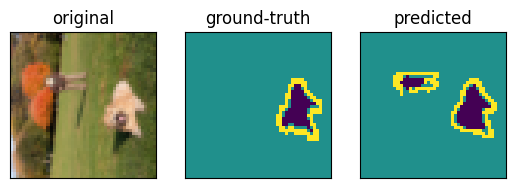

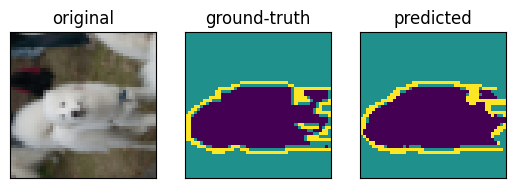

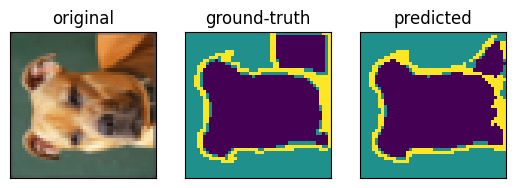

In [37]:
show_predictions(test_loader, unet_model, 3)

In [38]:
def dice_loss(pred, target):
    smooth = 1e-5
    dice = 0.
    pred = F.softmax(pred, dim=1).flatten(0,1)
    target = target.flatten(0,1)
    intersection = (pred * target).sum(dim=(-1,-2))
    union = pred.sum(dim=(-1,-2)) + target.sum(dim=(-1,-2))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [39]:
train_losses = []
train_acc = []

num_epochs=24
unet_model = UNet(in_channels=3,out_channels=3).to(device)
criterion = F.cross_entropy
optimizer = torch.optim.Adam(unet_model.parameters())
for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    train_loss = train_model(unet_model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    

epoch: 1


loss=0.5712682194287836 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.21it/s]


epoch: 2


loss=0.4404397941380946 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.14it/s] 


epoch: 3


loss=0.3855385015273169 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.17it/s] 


epoch: 4


loss=0.3349157471885236 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.33it/s] 


epoch: 5


loss=0.37707054069491774 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.01it/s]


epoch: 6


loss=0.36625883332468095 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.34it/s]


epoch: 7


loss=0.32162838073829564 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.12it/s]


epoch: 8


loss=0.3647608512834691 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.06it/s] 


epoch: 9


loss=0.29266764836370807 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.41it/s]


epoch: 10


loss=0.2835059233344585 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  5.90it/s] 


epoch: 11


loss=0.28532002601712686 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.38it/s]


epoch: 12


loss=0.2678437513700517 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.08it/s] 


epoch: 13


loss=0.25461339743864364 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.42it/s]


epoch: 14


loss=0.2931304053403894 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.18it/s] 


epoch: 15


loss=0.24425492385575986 batch_id=114: 100%|██████████| 115/115 [00:19<00:00,  6.05it/s]


epoch: 16


loss=0.2788144404054727 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.46it/s] 


epoch: 17


loss=0.2682469541375107 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.17it/s] 


epoch: 18


loss=0.2782428969784286 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.35it/s] 


epoch: 19


loss=0.24653075798426602 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.16it/s]


epoch: 20


loss=0.24421611700391851 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.15it/s]


epoch: 21


loss=0.23623554239947545 batch_id=114: 100%|██████████| 115/115 [00:17<00:00,  6.45it/s]


epoch: 22


loss=0.23744839039209986 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.12it/s]


epoch: 23


loss=0.21446844952808275 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.36it/s]


epoch: 24


loss=0.2073969949623074 batch_id=114: 100%|██████████| 115/115 [00:18<00:00,  6.19it/s] 


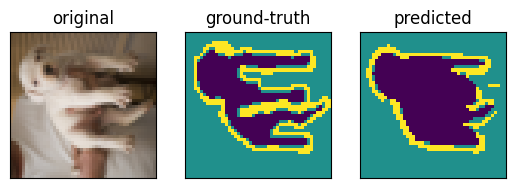

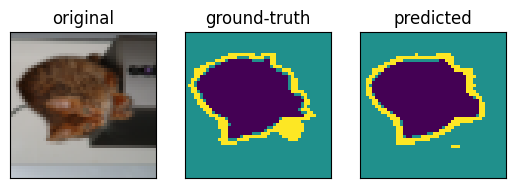

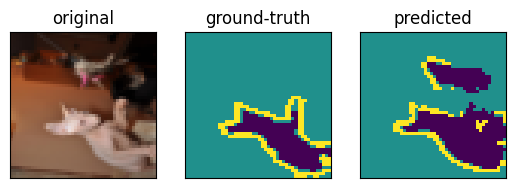

In [40]:
show_predictions(test_loader, unet_model, 3)

In [42]:
torch.save(unet_model.state_dict(), "unet.pt")